# Understanding train and test set
This dataset consists of customer transaction information with anonymized features. The 'target' column has labels 0/1 to predict whether a customer completed the transaction or not.
The aim of this excercise is to predict the target values for the test set given 199 features. 

## Importing the required libraries 

In [47]:
from tensorflow.python.framework import ops
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
import time
import datetime
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
print(os.listdir())
seed = 7
np.random.seed(seed)
# Any results you write to the current directory are saved as output.


['__notebook_source__.ipynb', 'Santander Prediction.csv', '.ipynb_checkpoints']


## Upload Train Data

In [48]:
train_file_name = '../input/train.csv'
train = pd.read_csv(train_file_name).sample(n = 1000, replace = True)

## Preview of train data

In [49]:
print(train.head(5))

             ID_code  target    var_0    var_1    var_2    var_3    var_4  \
61615    train_61615       0  10.2621  -3.3344  12.9237   5.8872  11.8427   
189636  train_189636       1   6.3696  -8.4281  10.6437   2.8882   9.6455   
49689    train_49689       0  15.5001  -1.6757  12.3445   7.9224  12.9886   
10742    train_10742       0  11.3650  -4.1980   5.4673  10.1757   8.5397   
53459    train_53459       0  12.6016 -10.4240   8.1915   5.7837  12.5771   

          var_5   var_6    var_7   ...     var_190  var_191  var_192  var_193  \
61615   -4.9290  4.9652  18.5539   ...      7.5100  12.6159   0.0087   5.0288   
189636  -5.8692  6.5267  20.7993   ...     10.0833  10.0535   0.7400   7.1955   
49689    2.8060  4.7846  19.7282   ...     12.3308  15.1780   3.0180   3.7709   
10742   -7.9062  5.7573  12.7150   ...      8.0849   9.7322   0.3776  12.6653   
53459  -15.3366  6.9890  17.0404   ...      3.6747   8.7973   1.1997   9.5132   

        var_194  var_195  var_196  var_197  var_19

## Upload Test Data

In [50]:
test_file_name = '../input/test.csv'
test = pd.read_csv(test_file_name).sample(n = 1000, replace = True)

## Preview of Test Data

In [51]:
print(test.head(5))

            ID_code    var_0   var_1    var_2   var_3    var_4    var_5  \
191496  test_191496  12.6353  0.9804  11.3721  6.1368  13.6643  -1.2800   
66814    test_66814   8.5555 -5.8959   9.4533  9.7693  13.4961  -1.1616   
127979  test_127979   6.3310  0.2175   7.6622  7.8871  11.9769  14.3777   
87664    test_87664  10.0255  0.1742  16.6022  5.8972  11.1463  -3.3166   
85753    test_85753  11.3727 -3.5743  15.5173  4.0083   9.5997 -20.1065   

         var_6    var_7   var_8   ...     var_190  var_191  var_192  var_193  \
191496  3.9770  12.8289  3.3477   ...      6.5847   7.7146   1.5553  10.6155   
66814   5.7446  13.1249  1.9142   ...     -3.0936   3.1899   1.8179   3.8143   
127979  7.0204  10.1192  0.1934   ...      7.0473   9.9882   0.8181   7.9256   
87664   5.6967  15.0267  6.3492   ...      0.8410   9.6845   1.2128   4.2907   
85753   5.3934  12.4357 -2.4113   ...     -2.6128   6.9408   0.6660   3.8034   

        var_194  var_195  var_196  var_197  var_198  var_199  
19149

### Duplicate train dataframe - X_tr

In [52]:
X_tr = train


### Assign target values to y

In [53]:
y = train['target']

In [54]:
X_tr = X_tr.drop(columns=['target'])

# Pre-processing train and test data

## Define a Standard Scaler
- Standardize all the anonymous features from the train set

In [55]:
scaler = StandardScaler()

### Standardize X_tr

In [56]:
# Exclude the ID Code column
data = X_tr.iloc[:, 1:]
scaler.fit(data)
StandardScaler(copy=True, with_mean=True, with_std=True)
X_tr.iloc[:, 1:] = scaler.transform(data)

### Standardize X_test

In [57]:
X_test = test
# Exclude the ID Code column
data = X_test.iloc[:, 1:]
scaler.fit(data)
StandardScaler(copy=True, with_mean=True, with_std=True)
X_test.iloc[:, 1:] = scaler.transform(data)

### Preview of X_tr after applying Standard Scaler

In [58]:
print(X_tr.head(5))

             ID_code     var_0     var_1     var_2     var_3     var_4  \
61615    train_61615 -0.137645 -0.394429  0.808992 -0.479357  0.414915   
189636  train_189636 -1.486629 -1.646852 -0.063758 -1.941244 -0.937310   
49689    train_49689  1.677634  0.013407  0.587283  0.512718  1.120138   
10742    train_10742  0.244575 -0.606768 -2.045206  1.611107 -1.617854   
53459    train_53459  0.673131 -2.137598 -1.002423 -0.529809  0.866888   

           var_5     var_6     var_7     var_8    ...      var_190   var_191  \
61615   0.024152 -0.556459  0.569572 -0.182183    ...     0.928546  1.773254   
189636 -0.093705  1.289994  1.223084  0.374711    ...     1.497498  0.927821   
49689   0.993762 -0.770016  0.911345  0.649790    ...     1.994417  2.618587   
10742  -0.349051  0.380189 -1.129810  0.380690    ...     1.055655  0.821812   
53459  -1.280478  1.836658  0.129075 -0.208637    ...     0.080567  0.513354   

         var_192   var_193   var_194   var_195   var_196   var_197   var_1

### Preview of X_test after applying Standard Scaler

In [59]:
print(X_test.head(5))

            ID_code     var_0     var_1     var_2     var_3     var_4  \
191496  test_191496  0.690510  0.691667  0.300565 -0.356706  1.557416   
66814    test_66814 -0.625076 -1.055210 -0.445300  1.413405  1.455555   
127979  test_127979 -1.342396  0.497857 -1.141527  0.496212  0.535542   
87664    test_87664 -0.151055  0.486857  2.333581 -0.473463  0.032538   
85753    test_85753  0.283368 -0.465424  1.911864 -1.393921 -0.904070   

           var_5     var_6     var_7     var_8    ...      var_190   var_191  \
191496  0.529098 -1.802003 -1.043428  0.914601    ...     0.714989  0.113624   
66814   0.544299  0.262992 -0.957738  0.478275    ...    -1.423592 -1.404740   
127979  2.539313  1.753443 -1.827865 -0.045500    ...     0.817208  0.876581   
87664   0.267629  0.207033 -0.407181  1.828193    ...    -0.554177  0.774668   
85753  -1.887944 -0.147297 -1.157256 -0.838315    ...    -1.317351 -0.146042   

         var_192   var_193   var_194   var_195   var_196   var_197   var_198  \


In [60]:
X = X_tr.iloc[:, 1:]

# Feature Engineering

## Heatmap - X_tr (features)
Heatmap for top 10 strongly correlated features. From the chart below we can assume that all features are independent of each other with very little correlation with each other

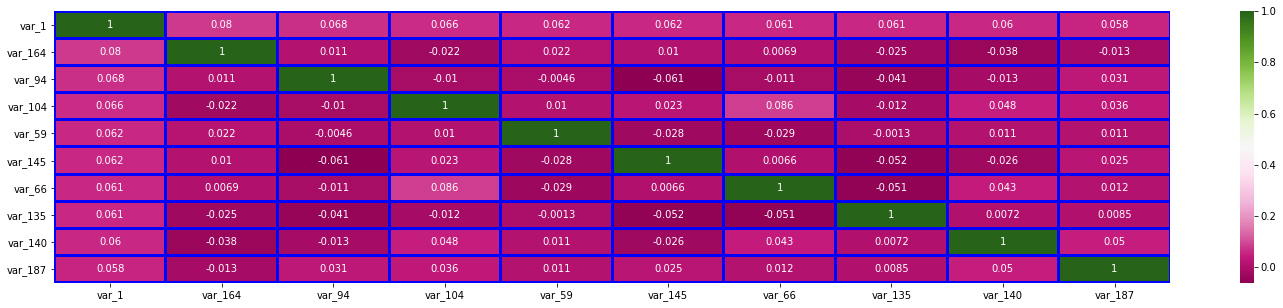

In [61]:
plt.figure(figsize=(25,5))

# correlation table
corr_train =  X_tr.iloc[:, 2:].corr()

# select top 20 highly correlated features
num = 10
col = corr_train.nlargest( num,  X_tr.iloc[:, 2:].columns).index
coeff = np.corrcoef(X_tr.iloc[:, 2:][col].values.T)

# heatmap
heatmp = sns.heatmap(coeff, annot = True, xticklabels = col.values, yticklabels = col.values, linewidth=2,cmap='PiYG', linecolor='blue')

# Model and Prediction

In [88]:
# larger model
def create_larger():
    # create model
    model = Sequential()
    model.add(Dense(120, input_dim=200, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(60, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=100, batch_size=5, verbose=1)))
pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#results = cross_val_score(pipeline, X, y, cv=kfold)
#print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
899/899 [==============================] - 3s 3ms/step - loss: 0.3903 - acc: 0.9010
Epoch 2/100
899/899 [==============================] - 1s 1ms/step - loss: 0.2088 - acc: 0.9110
Epoch 3/100
899/899 [==============================] - 1s 1ms/step - loss: 0.1568 - acc: 0.9110
Epoch 4/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0954 - acc: 0.9433
Epoch 5/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0564 - acc: 0.9844
Epoch 6/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0349 - acc: 0.9911
Epoch 7/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0139 - acc: 0.9989
Epoch 8/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0099 - acc: 0.9989
Epoch 9/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0372 - acc: 0.9844
Epoch 10/100
899/899 [==============================] - 1s 1ms/step - loss: 0.0442 - acc: 0.9844
Epoch 11/100
899/899 [=================

900/900 [==============================] - 1s 1ms/step - loss: 0.0153 - acc: 0.9989
Epoch 67/100
900/900 [==============================] - 1s 1ms/step - loss: 4.0802e-05 - acc: 1.0000
Epoch 68/100
900/900 [==============================] - 1s 1ms/step - loss: 5.0461e-04 - acc: 1.0000
Epoch 69/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0085 - acc: 0.9967
Epoch 70/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0278 - acc: 0.9956
Epoch 71/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 0.9989
Epoch 72/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0225 - acc: 0.9933
Epoch 73/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0150 - acc: 0.9967
Epoch 74/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0013 - acc: 0.9989
Epoch 75/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0087 - acc: 0.9967
Epoch 76/100
900/900 [=============

900/900 [==============================] - 1s 1ms/step - loss: 0.0400 - acc: 0.9922
Epoch 32/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0100 - acc: 0.9978
Epoch 33/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.9978
Epoch 34/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0280 - acc: 0.9933
Epoch 35/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 0.9989
Epoch 36/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 0.9989
Epoch 37/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0134 - acc: 0.9967
Epoch 38/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.9989
Epoch 39/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0158 - acc: 0.9989
Epoch 40/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.9989
Epoch 41/100
900/900 [=====================

900/900 [==============================] - 1s 1ms/step - loss: 0.0109 - acc: 0.9989
Epoch 97/100
900/900 [==============================] - 1s 1ms/step - loss: 7.9628e-04 - acc: 1.0000
Epoch 98/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 0.9989
Epoch 99/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0144 - acc: 0.9944
Epoch 100/100
100/100 [==============================] - 1s 9ms/step
Epoch 1/100
900/900 [==============================] - 3s 4ms/step - loss: 0.3954 - acc: 0.8889
Epoch 2/100
900/900 [==============================] - 1s 1ms/step - loss: 0.2289 - acc: 0.9111
Epoch 3/100
900/900 [==============================] - 1s 1ms/step - loss: 0.1599 - acc: 0.9111
Epoch 4/100
900/900 [==============================] - 1s 1ms/step - loss: 0.1122 - acc: 0.9289
Epoch 5/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0610 - acc: 0.9778
Epoch 6/100
900/900 [==============================] - 1s 1ms/step - los

Epoch 61/100
900/900 [==============================] - 1s 1ms/step - loss: 2.7466e-04 - acc: 1.0000
Epoch 62/100
900/900 [==============================] - 1s 1ms/step - loss: 7.6245e-04 - acc: 1.0000
Epoch 63/100
900/900 [==============================] - 1s 1ms/step - loss: 2.3469e-04 - acc: 1.0000
Epoch 64/100
900/900 [==============================] - 1s 1ms/step - loss: 8.2631e-05 - acc: 1.0000
Epoch 65/100
900/900 [==============================] - 1s 1ms/step - loss: 2.0800e-04 - acc: 1.0000
Epoch 66/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0020 - acc: 1.0000
Epoch 67/100
900/900 [==============================] - 1s 2ms/step - loss: 9.5806e-04 - acc: 1.0000
Epoch 68/100
900/900 [==============================] - 1s 1ms/step - loss: 5.6177e-04 - acc: 1.0000
Epoch 69/100
900/900 [==============================] - 1s 1ms/step - loss: 2.7575e-05 - acc: 1.0000
Epoch 70/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 0.998

900/900 [==============================] - 1s 1ms/step - loss: 0.0013 - acc: 1.0000
Epoch 26/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0024 - acc: 0.9989
Epoch 27/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0010 - acc: 1.0000
Epoch 28/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 1.0000
Epoch 29/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0024 - acc: 0.9989
Epoch 30/100
900/900 [==============================] - 1s 1ms/step - loss: 7.9677e-04 - acc: 1.0000
Epoch 31/100
900/900 [==============================] - 1s 1ms/step - loss: 7.5690e-04 - acc: 1.0000
Epoch 32/100
900/900 [==============================] - 1s 1ms/step - loss: 9.0180e-04 - acc: 1.0000
Epoch 33/100
900/900 [==============================] - 1s 1ms/step - loss: 5.4602e-04 - acc: 1.0000
Epoch 34/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0156 - acc: 0.9956
Epoch 35/100
900/900 [=====

901/901 [==============================] - 1s 1ms/step - loss: 1.2459e-04 - acc: 1.0000
Epoch 91/100
901/901 [==============================] - 1s 1ms/step - loss: 5.4301e-04 - acc: 1.0000
Epoch 92/100
901/901 [==============================] - 1s 1ms/step - loss: 6.2189e-04 - acc: 1.0000
Epoch 93/100
901/901 [==============================] - 1s 1ms/step - loss: 1.0698e-04 - acc: 1.0000
Epoch 94/100
901/901 [==============================] - 1s 1ms/step - loss: 5.2816e-05 - acc: 1.0000
Epoch 95/100
901/901 [==============================] - 1s 1ms/step - loss: 1.7157e-04 - acc: 1.0000
Epoch 96/100
901/901 [==============================] - 1s 1ms/step - loss: 1.1588e-05 - acc: 1.0000
Epoch 97/100
901/901 [==============================] - 1s 1ms/step - loss: 1.2080e-04 - acc: 1.0000
Epoch 98/100
901/901 [==============================] - 1s 1ms/step - loss: 6.4614e-04 - acc: 1.0000
Epoch 99/100
901/901 [==============================] - 1s 1ms/step - loss: 6.5267e-05 - acc: 1.0000
Epo

In [92]:
pipeline.fit(X,y)
y_test = pipeline.predict(X_test.iloc[:, 1:])
y_test[:5]

Epoch 1/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4059 - acc: 0.8940
Epoch 2/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.2304 - acc: 0.9110
Epoch 3/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1520 - acc: 0.9110
Epoch 4/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0967 - acc: 0.9430
Epoch 5/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0490 - acc: 0.9890
Epoch 6/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0370 - acc: 0.9860
Epoch 7/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0313 - acc: 0.9910
Epoch 8/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0174 - acc: 0.9950
Epoch 9/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 0.9990
Epoch 10/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0096 - acc: 0.9980
Epoch 11/100
1000/1

1000/1000 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.9990
Epoch 84/100
1000/1000 [==============================] - 1s 1ms/step - loss: 8.2822e-04 - acc: 1.0000
Epoch 85/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0130 - acc: 0.9980
Epoch 86/100
1000/1000 [==============================] - 1s 1ms/step - loss: 4.1452e-04 - acc: 1.0000
Epoch 87/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0020 - acc: 0.9990
Epoch 88/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 0.9970
Epoch 89/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0065 - acc: 0.9990
Epoch 90/100
1000/1000 [==============================] - 1s 1ms/step - loss: 7.2680e-04 - acc: 1.0000
Epoch 91/100
1000/1000 [==============================] - 1s 1ms/step - loss: 3.6549e-04 - acc: 1.0000
Epoch 92/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.9990
Epoch 9

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [93]:
df = pd.DataFrame()#(y_test, columns = ['Target'])
df['ID_code'] = X_test['ID_code']
df1 = pd.DataFrame(y_test, columns = ['Target'])
df['Target'] = df1['Target']
id_code = X_test['ID_code']
submission = df
submission.to_csv('Santander Prediction.csv', index=False)